# Random forest au secours du titanic

## Importer les données Titanic ".csv"

In [1]:
import pandas as pd

In [2]:
# Lecture du fichier ".csv"
path = "~/Documents/PDS/Cours/Data/train.csv"
train = pd.read_csv(path, sep=",")

# Affichage des cinq premières lignes
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Création du modèle

In [3]:
def parse_model2(X):
    if "Survived" not in X.columns:
        raise ValueError("target column survived should belong to df")
    target = X["Survived"]
    to_dummy = ['Pclass', 'Sex']
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum], prefix=dum)
        for col in split_temp:
            X[col] = split_temp[col]
        del X[dum]
    X['Age'] = X['Age'].fillna(X['Age'].median())
    to_del = ["PassengerId", "Name", "Cabin", "Embarked", "Survived", "Ticket"]
    for col in to_del:
        del X[col]
    return X, target

x, y = parse_model2(train.copy())

## Application du Random Forest

In [4]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

C:\Users\Charline\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# X2 = X.drop('is_child', 1)
# rf = RandomForestClassifier(n_estimators=10,max_depth=4, min_samples_split=2, min_samples_leaf=1)

def compute_score(clf, X, y, cv=5):
    """compute score in a classification modelisation.
    clf: classifier
    X: features
    y:target
    """
    xval = cross_val_score(clf, X, y, cv=5)
    print("Accurancy: %0.2f (+/- %0.2f)" % (xval.mean(), xval.std() * 2))
    return xval

rf = RandomForestClassifier()
compute_score(rf, x, y)

Accurancy: 0.81 (+/- 0.05)


array([ 0.80446927,  0.81564246,  0.83707865,  0.76966292,  0.83615819])

In [6]:
# On obtient directement un meilleur score que la régression logisique sans même :
# - utiliser la variable is child
# - ni chercher les paramètres optiomaux en terme de nombre d'arbres, profondeur maximale etc...

In [7]:
x['is_child'] = x["Age"] < 8
cols = [c for c in x.columns if 'Age' not in c]
X1 = x[cols]
compute_score(rf, X1, y)

Accurancy: 0.81 (+/- 0.06)


array([ 0.77094972,  0.79329609,  0.85393258,  0.81460674,  0.81920904])

In [8]:
X1.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,is_child
0,1,0,7.2500,0,0,1,0,1,False
1,1,0,71.2833,1,0,0,1,0,False
2,0,0,7.9250,0,0,1,1,0,False
3,1,0,53.1000,1,0,0,1,0,False
4,0,0,8.0500,0,0,1,0,1,False


In [9]:
import numpy as np

In [10]:
rf.fit(X1, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
indices

array([2, 6, 7, 5, 0, 1, 8, 3, 4], dtype=int64)

In [11]:
X1.columns[indices[0]]

'Fare'

In [12]:
def clf_importances(X, clf):
    import pylab as pl
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    pl.title("Feature importances")
    for tree in clf.estimators_:
        pl.plot(range(X.shape[1]), tree.feature_importances_[indices], "r")
        pl.plot(range(X.shape[1]), importances[indices], "b")
        pl.show();
    for f in range (X.shape[1]):
        print("%d. feature : %s (%f)" %(f + 1, X.columns[indices[f]], importances[indices[f]]))

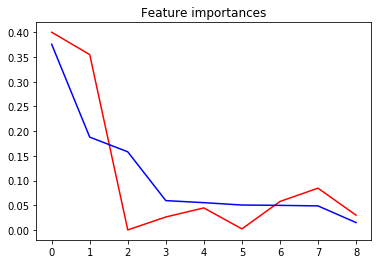

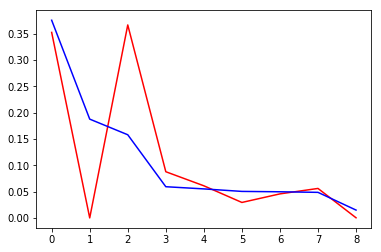

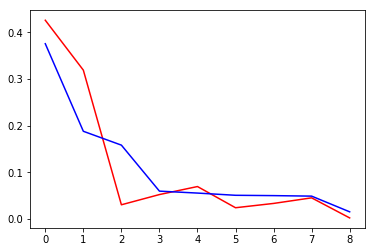

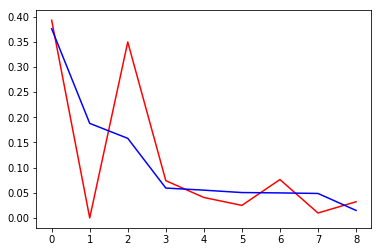

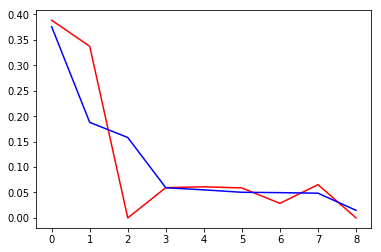

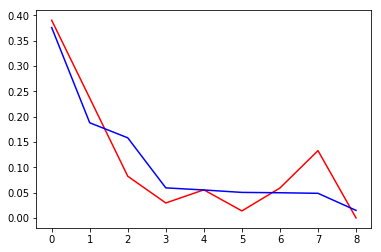

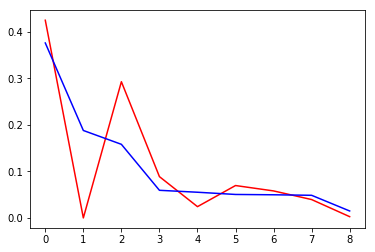

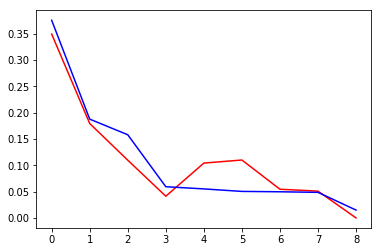

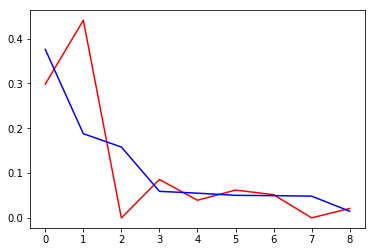

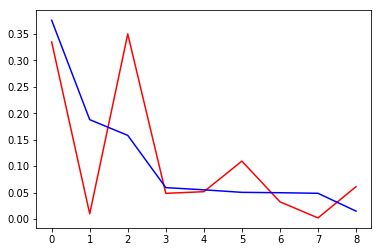

1. feature : Fare (0.375879)
2. feature : Sex_female (0.187873)
3. feature : Sex_male (0.158124)
4. feature : SibSp (0.059329)
5. feature : is_child (0.055171)
6. feature : Pclass_1 (0.050407)
7. feature : Parch (0.049702)
8. feature : Pclass_3 (0.048608)
9. feature : Pclass_2 (0.014908)


In [13]:
rf.fit(X1,y)
clf_importances(X1,rf)

In [14]:
# On se rend compte que en général, les cinq meilleurs variables permettent d'expliquer 80% de la variance du pb. 
# Elle classe et nous donne la contribution agrégée de chaque variable.
# Cette superposition compare l'importance de chaque variable au global à sa contribution sur chaque arbre.
# On rq également que les variables Fare et Age totalement délaissées par le modèle linéaire se retrouvent tout en haut du classement.
# Elles apparaissent plus souvent et plus haut dans les arbres. Mais attention, c'est aussi et surtout parce que Age et Fare sont des
# variables continues de grandes dispersions.

In [15]:
# Récupérer le titre de chaques personnes
# Ou alors checker où y'à la parenthèse dans la colonne

def parse_model_final(X):
    if "Survived" not in X.columns:
        raise ValueError("target column survived should belong to df")
    target = X["Survived"]
    X['Title'] = X['Name'].map(lambda x: x.split(',')[1].split('.')[0])
    X['Surname'] = X['Name'].map(lambda x: '(' in x)
    X['Cabin'] = X['Cabin'].map(lambda x: x[0] if not pd.isnull(x) else -1)
    to_dummy = X[["Pclass", "Sex", "Title", "Embarked", "Cabin"]]
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum], prefix=dum)
        X = X.join(split_temp)
        del X[dum]

    X['Age'] = X['Age'].fillna(X['Age'].median())
    X['is_child'] = X['Age'] <= 8
    to_del = ["PassengerId", "Name", "Survived" , "Ticket"]
    for col in to_del:
        del X[col]
    return X, target

In [16]:
X, target = parse_model_final(train.copy())

In [17]:
compute_score(rf, X, target)

Accurancy: 0.81 (+/- 0.05)


array([ 0.81005587,  0.77653631,  0.83707865,  0.78651685,  0.83050847])

## Chercher les meilleurs paramètres

In [19]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(n_estimators=100)
parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10,20,None),'max_features':('sqrt','log2',None)}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1)
grid_search.fit(X, target)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# TO DO : Appliquer le modèle au jeu de test
# score = grid_search.best_estimator_.score(X_test,y_test)
# print("Score test: " + str(score))

Best score: 0.840
Best parameters set:
	max_depth: 6
	max_features: None


## Utilisation avec des meilleurs paramètres

In [22]:
rf = RandomForestClassifier(n_estimators=100, max_depth=7, max_features = None)

In [23]:
compute_score(rf, X, target)

Accurancy: 0.84 (+/- 0.05)


array([ 0.83798883,  0.80446927,  0.86516854,  0.80337079,  0.86440678])

## Appliquer le modèle au jeu de test

## Calculer la spécificité et la sensibilité/ Précision